In [2]:
import nltk
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [3]:
# load data
data = pd.read_csv('reddit_data.csv')
data.head()


,title,body,class
0,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,True
1,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",True
2,I told a goth girl she looked like a clown.,I was four.,False
3,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,True
4,"[AITA] I 'hacked' our house router, changed th...",Backstory: I'm a semi-professional competitive...,True


In [4]:
sid = SentimentIntensityAnalyzer()
score = sid.polarity_scores('this is sentence is the shit')
score

{'neg': 0.404, 'neu': 0.449, 'pos': 0.146, 'compound': -0.5106}

In [5]:
body_sentiment_scores = [sid.polarity_scores(body) for body in data['body']]
title_sentiment_scores = [sid.polarity_scores(title) for title in data['title']]
#body_sentiment_scores

In [6]:
data['body_pos'] = [score['pos'] for score in body_sentiment_scores]
data['body_neg'] = [score['neg'] for score in body_sentiment_scores]
data['body_neu'] = [score['neu'] for score in body_sentiment_scores]
data['body_comp'] = [score['compound'] for score in body_sentiment_scores]

data['title_pos'] = [score['pos'] for score in title_sentiment_scores]
data['title_neg'] = [score['neg'] for score in title_sentiment_scores]
data['title_neu'] = [score['neu'] for score in title_sentiment_scores]
data['title_comp'] = [score['compound'] for score in title_sentiment_scores]

data.to_csv('sentiment-data.csv', index=False)
data.head()

,title,body,class,body_pos,body_neg,body_neu,body_comp,title_pos,title_neg,title_neu,title_comp
0,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,True,0.169,0.068,0.763,0.7692,0.000,0.000,1.000,0.0000
1,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",True,0.088,0.050,0.862,0.8591,0.000,0.000,1.000,0.0000
2,I told a goth girl she looked like a clown.,I was four.,False,0.000,0.000,1.000,0.0000,0.294,0.000,0.706,0.3612
3,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,True,0.132,0.054,0.814,0.9075,0.000,0.263,0.737,-0.3612
4,"[AITA] I 'hacked' our house router, changed th...",Backstory: I'm a semi-professional competitive...,True,0.077,0.048,0.875,0.9174,0.000,0.000,1.000,0.0000


In [7]:
data = pd.read_csv('sentiment-data.csv')
data.head()

,title,body,class,body_pos,body_neg,body_neu,body_comp,title_pos,title_neg,title_neu,title_comp
0,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,True,0.169,0.068,0.763,0.7692,0.000,0.000,1.000,0.0000
1,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",True,0.088,0.050,0.862,0.8591,0.000,0.000,1.000,0.0000
2,I told a goth girl she looked like a clown.,I was four.,False,0.000,0.000,1.000,0.0000,0.294,0.000,0.706,0.3612
3,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,True,0.132,0.054,0.814,0.9075,0.000,0.263,0.737,-0.3612
4,"[AITA] I 'hacked' our house router, changed th...",Backstory: I'm a semi-professional competitive...,True,0.077,0.048,0.875,0.9174,0.000,0.000,1.000,0.0000


In [8]:
x = data.drop(['title', 'body', 'class'], axis=1)
y = data['class']
x.head()

,body_pos,body_neg,body_neu,body_comp,title_pos,title_neg,title_neu,title_comp
0,0.169,0.068,0.763,0.7692,0.000,0.000,1.000,0.0000
1,0.088,0.050,0.862,0.8591,0.000,0.000,1.000,0.0000
2,0.000,0.000,1.000,0.0000,0.294,0.000,0.706,0.3612
3,0.132,0.054,0.814,0.9075,0.000,0.263,0.737,-0.3612
4,0.077,0.048,0.875,0.9174,0.000,0.000,1.000,0.0000


In [9]:
# run SMOTE
print(len(x))
sm = SMOTE('minority')
x, y = sm.fit_resample(x, y)
print(len(x))
print(list(y).count(True))

2431
3490
1745


In [10]:
knn = KNeighborsClassifier(n_neighbors=5)
cv = cross_val_score(knn, x, y, cv=10)
print(cv)
y_pred = cross_val_predict(knn, x, y, cv=10)
report = classification_report(y, y_pred)
print(report)

[0.62750716 0.63610315 0.61891117 0.61604585 0.67335244 0.71060172
 0.71633238 0.67335244 0.75358166 0.67908309]
              precision    recall  f1-score   support

       False       0.72      0.56      0.63      1745
        True       0.64      0.78      0.70      1745

    accuracy                           0.67      3490
   macro avg       0.68      0.67      0.67      3490
weighted avg       0.68      0.67      0.67      3490



In [11]:
param_grid = {'n_neighbors': [i for i in range(1,31)]}
gridcv = GridSearchCV(knn, param_grid)
gridcv.fit(x, y)
print(gridcv.best_params_)
gridcv.best_score_
y_pred = cross_val_predict(gridcv, x, y, cv=10)
report = classification_report(y, y_pred)
print(report)

{'n_neighbors': 1}
              precision    recall  f1-score   support

       False       0.83      0.66      0.73      1745
        True       0.72      0.87      0.78      1745

    accuracy                           0.76      3490
   macro avg       0.77      0.76      0.76      3490
weighted avg       0.77      0.76      0.76      3490



In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
pca = PCA(n_components = 0.95)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
print(x_train_pca.shape)

# apply to test set
x_test_pca = pca.transform(x_test)
print(x_test.shape)

(2792, 3)
(698, 8)


In [13]:
param_grid = {'n_neighbors': [i for i in range(1,31)]}
gridcv = GridSearchCV(knn, param_grid)
gridcv.fit(x_train, y_train)
print(gridcv.best_params_)
gridcv.best_score_

{'n_neighbors': 1}


0.7235013881675547

In [14]:
tree = DecisionTreeClassifier(criterion='entropy')

param_grid = {
    'max_depth': range(1,16),
    'min_samples_leaf': range(5,40,5),
}
gridcv = GridSearchCV(tree, param_grid)
gridcv.fit(x_train, y_train)
print(gridcv.best_params_)
gridcv.best_score_

{'max_depth': 15, 'min_samples_leaf': 10}


0.5823814928090997

In [15]:
rand_for = RandomForestClassifier()
param_grid = {
    'max_depth': range(4,10),
    'min_samples_leaf': range(1,5),
    'max_features': ('sqrt', 'log2')
}
gridcv = GridSearchCV(rand_for, param_grid)
gridcv.fit(x_train, y_train)
print(gridcv.best_params_)
gridcv.best_score_

{'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 1}


0.6246426991363225

Clustering

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import plotly
import plotly.graph_objs as go
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
%config InlineBackend.figure_format='retina'
x.head()


,body_pos,body_neg,body_neu,body_comp,title_pos,title_neg,title_neu,title_comp
0,0.169,0.068,0.763,0.7692,0.000,0.000,1.000,0.0000
1,0.088,0.050,0.862,0.8591,0.000,0.000,1.000,0.0000
2,0.000,0.000,1.000,0.0000,0.294,0.000,0.706,0.3612
3,0.132,0.054,0.814,0.9075,0.000,0.263,0.737,-0.3612
4,0.077,0.048,0.875,0.9174,0.000,0.000,1.000,0.0000


Dimensionality Reduction

3490
Big variance drop off after 4th PCA feature
             0         1
0     1.112382 -0.994887
1    -0.291204 -1.950937
2    -0.325246 -2.587142
3     0.066496  0.471194
4    -0.460040 -2.087597
...        ...       ...
3485 -1.529504 -0.830304
3486  0.258110 -1.274106
3487 -1.362803 -0.787568
3488 -1.249906  0.787779
3489  0.033587 -2.343835

[3490 rows x 2 columns]


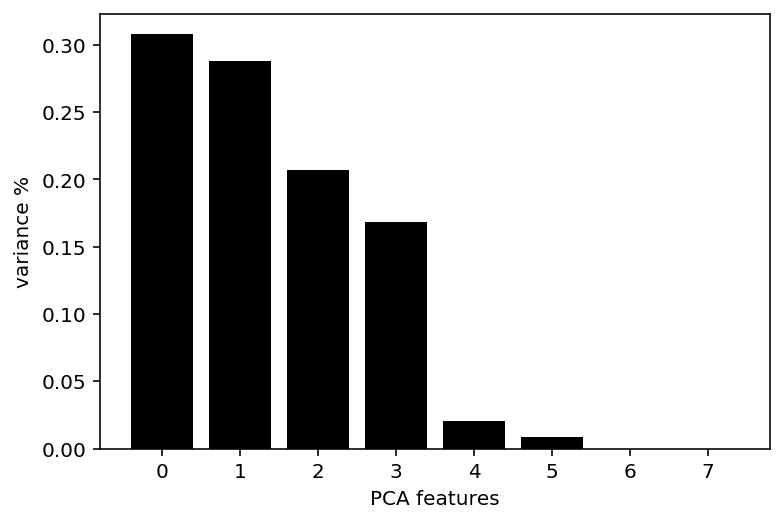

In [64]:
print(len(x))
X_std = StandardScaler().fit_transform(x)
# Create a PCA instance: pca
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
print("Big variance drop off after 4th PCA feature")
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_std)
PCA_components = pd.DataFrame(principalComponents)
print(PCA_components)

Text(0, 0.5, 'PCA 2')

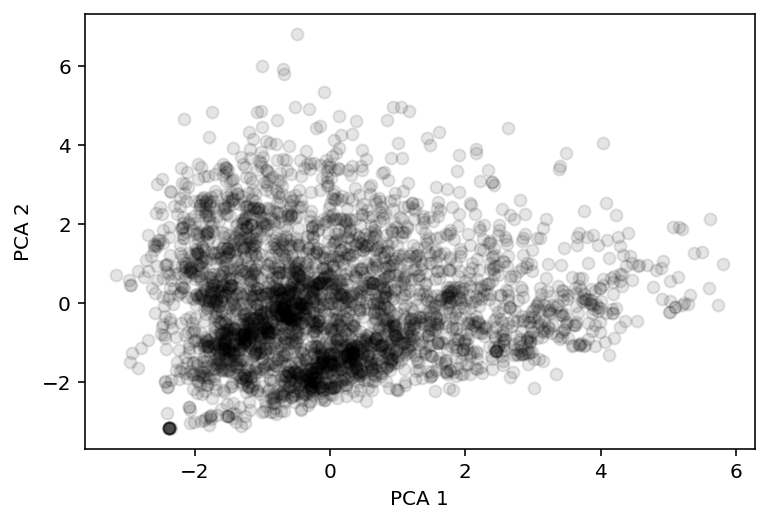

In [72]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')


K-means

In [73]:
kmeans = KMeans(n_clusters = 2) #Want 2 clusters; Asshole or not
kmeans.fit(PCA_components)
silhouette = silhouette_score(PCA_components, kmeans.labels_, metric='euclidean')
print(kmeans.inertia_)
print(silhouette)

10910.947918445765
0.35740868836609874


DBSCAN

Elbow point at approx eps = .2


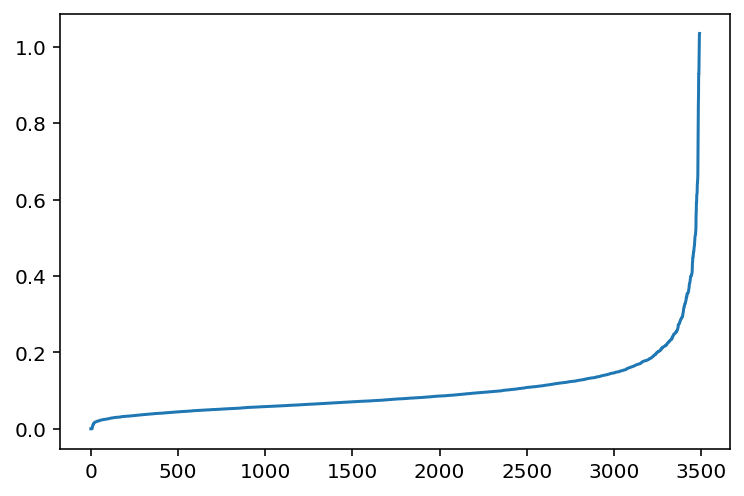

In [75]:
neighbors = NearestNeighbors(n_neighbors =4).fit(PCA_components)
distance, ind = neighbors.kneighbors(PCA_components, n_neighbors=4)
distanceDec = sorted(distance[:,3], reverse=False)
plt.plot(list(range(1,len(PCA_components)+1)), distanceDec)
print("Elbow point at approx eps = .2")

In [90]:
density_cluster = DBSCAN(eps = .2, min_samples = 4).fit(PCA_components)

labels = density_cluster.labels_
correct = 0
tot = 0 
for i in range(0,len(labels)):
    if labels[i] == y[i]:
        correct +=1
    tot +=1
accuracy = correct/tot
print(accuracy)
silhouette = silhouette_score(PCA_components, labels, metric='euclidean')
print(silhouette)

0.4684813753581662
-0.14112053694243923


HAC

cutoff around 50 on y axis


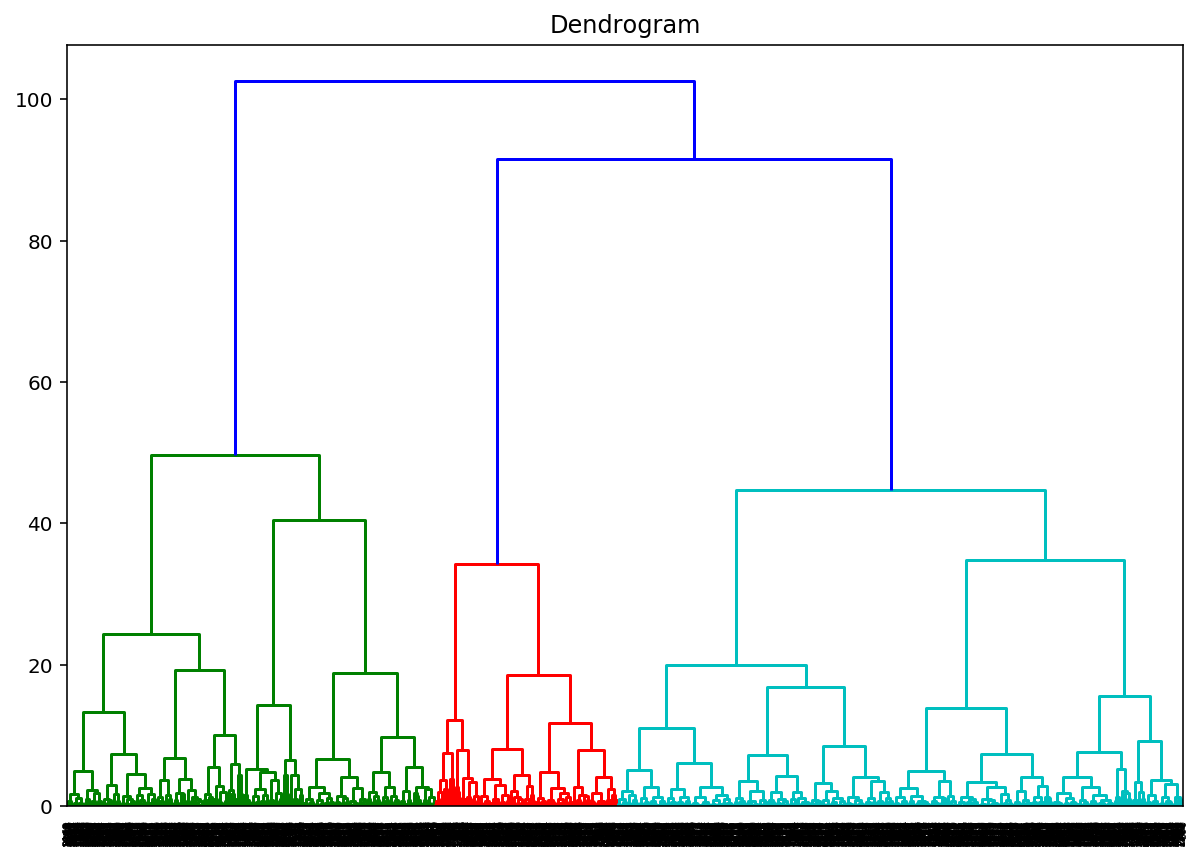

In [99]:
df = PCA_components.iloc[:,:].values
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10,7))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(df, method='ward'))
print('cutoff around 50 on y axis')

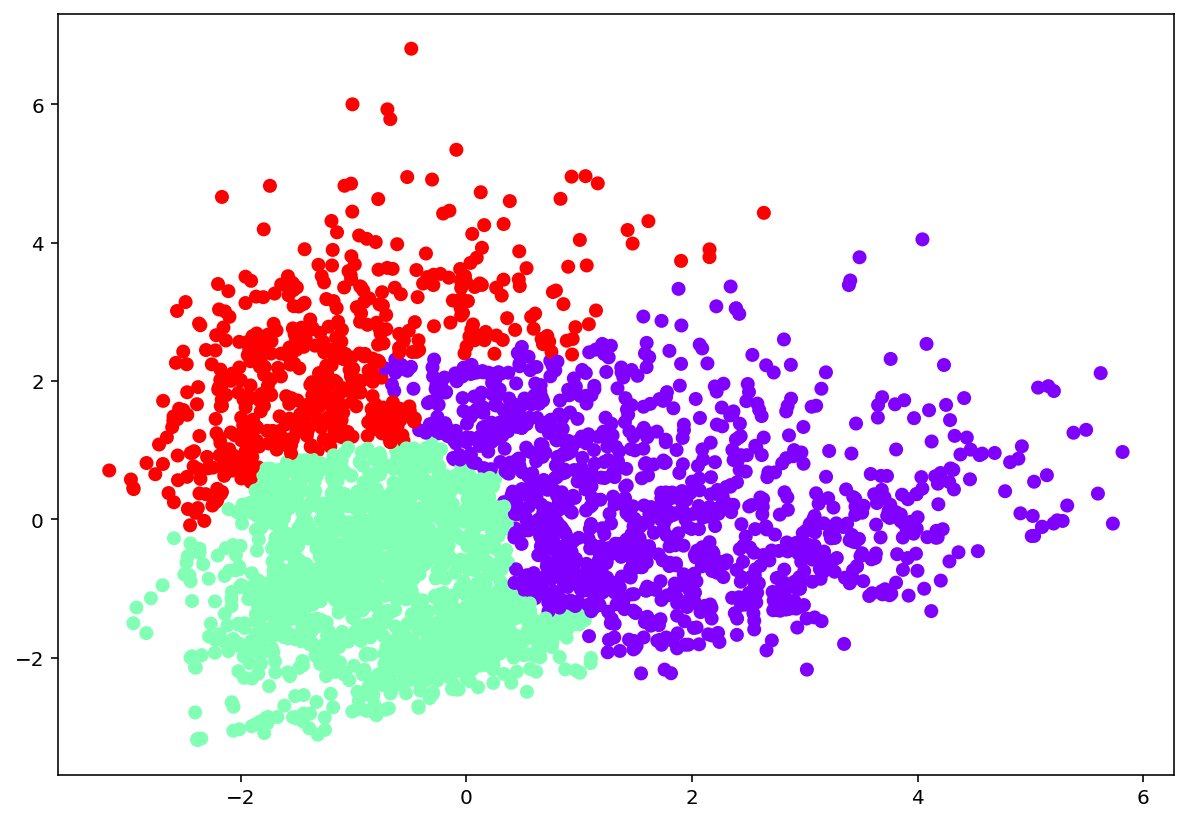

In [98]:
hac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hac.fit_predict(df)
plt.figure(figsize=(10, 7))
plt.scatter(df[:,0], df[:,1], c=hac.labels_, cmap='rainbow')
